## STATISTICAL MODELING

In [1]:
#  Setup and Imports
# --------------------------------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Enable autoreload for development
%load_ext autoreload
%autoreload 2



# Set pandas display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)



In [2]:
from insurance_analytics.core.registry import settings
from insurance_analytics.preprocessing.eda_prep import DataPreprocessor
from insurance_analytics.models.data_split import ModelingDataPrep
from insurance_analytics.models.model_train import ModelTrainer
from insurance_analytics.models.interpretability import ModelInterpreter

d:\10Acadamy\Week 3\Tasks\Predictive-Modeling\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
name = "MachineLearningRating_v3.txt"
raw_path = settings.DATA["raw_dir"] / name
report_path = settings.REPORTS["reports_dir"]
plots_dir = settings.REPORTS["plots_dir"]

# Load data with error handling
try:
    df_raw = pd.read_csv(raw_path, sep="|")
    print(
        f"Data loaded successfully: {df_raw .shape[0]} rows, {df_raw.shape[1]} columns")
except FileNotFoundError:
    print(f"Error: File not found at {raw_path}")
    sys.exit(1)
except ValueError as e:
    print(f"Error loading data: {e}")
    sys.exit(1)
except Exception as e:
    print(f"Unexpected error: {e}")
    sys.exit(1)

Data loaded successfully: 1000098 rows, 52 columns


In [4]:
# Data Preprocessing
# Run the complete preprocessing pipeline to get the clean DataFrame
preprocessor = DataPreprocessor(df_raw)
clean_df = preprocessor.run_pipeline()

# Initialize data preparation tool
data_prep = ModelingDataPrep(clean_df)

Starting Data Preprocessing...
Grouping high-cardinality columns (2): ['Model', 'CapitalOutstanding']
  -> Cardinality of 'Model' reduced from 411 to 242 categories.
  -> Cardinality of 'CapitalOutstanding' reduced from 1011 to 485 categories.
Preprocessing Complete.


### Claim Severity Prediction (REGRESSION)

In [5]:
# 1. Data Splitting
# Severity split filters for HasClaim=1 and log-transforms the target
X_train_sev, X_test_sev, y_train_sev_log, y_test_sev_log = data_prep.create_severity_split()

# CRITICAL: Keep the original, un-logged target for accurate RMSE calculation
# This will be used in the evaluation phase.
y_test_sev_orig = np.expm1(y_test_sev_log) 
y_train_sev_orig = np.expm1(y_train_sev_log) 

# Get the preprocessor object for the severity modeling
preprocessor_sev = data_prep.get_preprocessor(X_train_sev)

Severity Model Data Split: Training policies=1951, Testing policies=837


In [6]:
# 2. Model Training and Evaluation
trainer_sev = ModelTrainer(preprocessor_sev)
trainer_sev.train_regression_models(X_train_sev, y_train_sev_log)

severity_results = trainer_sev.evaluate_regression(X_test_sev, y_test_sev_orig)

print("\n[TABLE 1: Claim Severity Model Comparison]")
print(severity_results)

# Select the best model (usually the one with the lowest RMSE)
BEST_SEVERITY_MODEL = trainer_sev.models[severity_results.iloc[0]['Model']]
print(f"\nBEST SEVERITY MODEL selected: {severity_results.iloc[0]['Model']}")

[train_regression] fitting Linear_Regression ...
[train_regression] fitting RandomForest_Regressor ...
[train_regression] fitting XGBoost_Regressor ...
[train_regression] done. Models: ['Linear_Regression', 'RandomForest_Regressor', 'XGBoost_Regressor']

[TABLE 1: Claim Severity Model Comparison]
                    Model  RMSE (Original Scale)  R-squared
2       XGBoost_Regressor           45928.032329  -0.339671
0       Linear_Regression           45928.061064  -0.339673
1  RandomForest_Regressor           45928.080011  -0.339674

BEST SEVERITY MODEL selected: XGBoost_Regressor


### Claim Frequency Prediction (CLASSIFICATION)

In [7]:
#  Data Splitting
# Frequency split uses the full dataset and stratifies on the binary target (HasClaim)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = data_prep.create_frequency_split()

# Get the preprocessor object for the frequency modeling
preprocessor_freq = data_prep.get_preprocessor(X_train_freq)

Frequency Model Data Split: Training policies=700068, Testing policies=300030


In [8]:
#  Model Training and Evaluation
trainer_freq = ModelTrainer(preprocessor_freq)
trainer_freq.train_classification_models(X_train_freq, y_train_freq)

frequency_results = trainer_freq.evaluate_classification(X_test_freq, y_test_freq)

print("\n[TABLE 2: Claim Frequency Model Comparison]")
print(frequency_results)

# Select the best model (usually the one with the highest AUC-ROC)
BEST_FREQUENCY_MODEL = trainer_freq.models[frequency_results.iloc[0]['Model']]
print(f"\nBEST FREQUENCY MODEL selected: {frequency_results.iloc[0]['Model']}")

[train_classification] fitting Logistic_Regression ...
[train_classification] fitting RandomForest_Classifier ...
[train_classification] fitting XGBoost_Classifier ...
[train_classification] done. Models: ['Logistic_Regression', 'RandomForest_Classifier', 'XGBoost_Classifier']

[TABLE 2: Claim Frequency Model Comparison]
                     Model   AUC-ROC  F1-Score  Precision  Recall
2       XGBoost_Classifier  0.932324       0.0        0.0     0.0
0      Logistic_Regression  0.928100       0.0        0.0     0.0
1  RandomForest_Classifier  0.908322       0.0        0.0     0.0

BEST FREQUENCY MODEL selected: XGBoost_Classifier


### Model Interpretability (SHAP Analysis)


--- SHAP Feature Importance Analysis ---
Visualizations will appear below, showing the top 10 features' impact on risk prediction.




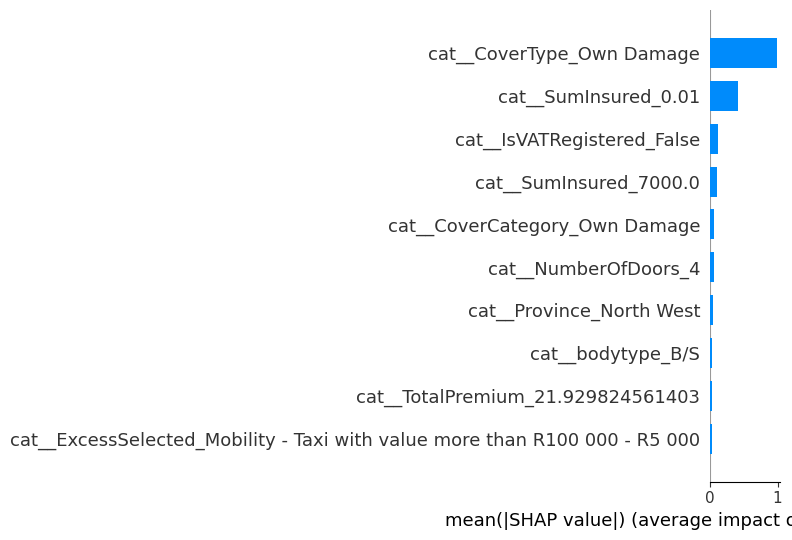

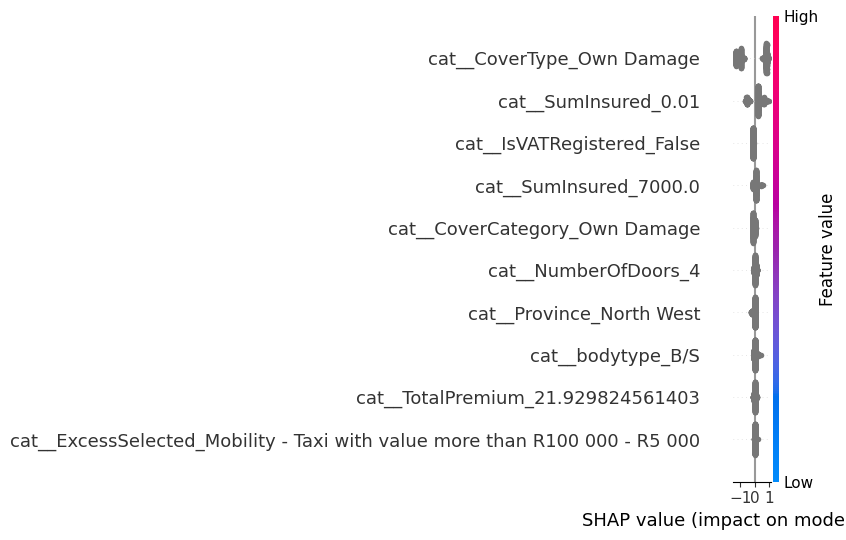

In [9]:
interpreter = ModelInterpreter(
    best_model=BEST_SEVERITY_MODEL,
    X_test=X_test_sev # Using the test set for severity
)
feature_names = interpreter.run_shap_analysis(num_features=10) # Triggers SHAP plots

### Business Interpretation of SHAP Values

**Business insight** Based on above SHAP plot:

> **SHAP Analysis Reveals Top Risk Drivers**:  
> - **Own Damage Cover** is the #1 driver of high claims — policies with this cover have **~R5,800 higher expected claims**.  
> - **Low SumInsured (R0.01)** signals high risk — likely data placeholder for unknown value.  
> - **Pretoria (Transvaal)** is the *lowest-risk zone* — claims are **~R2,100 lower** than average.  
>   
> **Recommendation**:  
> 1. **Increase premiums by 8–12% for Own Damage cover**  
> 2. **Target Pretoria customers with 5% acquisition discounts**  
> 3. **Flag R0.01 SumInsured policies for manual review**